In [1]:
import numpy as np
from numpy import cos, sin
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# read data
acc_1 = pd.read_csv(r'data\24_steps\Accelerometer.csv')
gyro_1 = pd.read_csv(r'data\24_steps\Gyroscope.csv')
gravity = pd.read_csv(r'data\24_steps\Gravity.csv')

In [3]:
# order column
acc_1 = acc_1[['time','x','y','z']]
gyro_1 = gyro_1[['time','x','y','z']]
gravity = gravity[['time','x','y','z']]

In [4]:
# add gravity to acceleration
acc_1.iloc[:,1:4] = acc_1.iloc[:,1:4] + gravity.iloc[:,1:4]

acc_1.head()

,time,x,y,z
0,1610046699485415200,-0.404227,4.464037,8.661963
1,1610046699559535000,-0.411410,4.435307,8.667949
2,1610046699633655300,-0.436549,4.417350,8.653584
3,1610046699668628500,-0.492813,4.399394,8.651189
4,1610046699673643500,-0.482039,4.402985,8.606896


In [5]:
acc_1= acc_1.iloc[5:,:]
gyro_1= gyro_1.iloc[5:,:]

acc_1 = acc_1.reset_index()
gyro_1 = gyro_1.reset_index()

acc_1.head()

,index,time,x,y,z
0,5,1610046699678658600,-0.476053,4.398196,8.568589
1,6,1610046699683673600,-0.482039,4.383831,8.547041
2,7,1610046699688798500,-0.499995,4.365874,8.532676
3,8,1610046699693923600,-0.533514,4.344326,8.532676
4,9,1610046699699048400,-0.567033,4.322779,8.529084


In [6]:
# Total acceleration
acc_1['acceleration'] =np.sqrt(acc_1['x']**2+acc_1['y']**2+acc_1['z']**2)

In [7]:
# # join dataframes
# df1 = acc_1.join(gyro_1.set_index('time'),on="time",lsuffix='_acc', rsuffix='_gyro')


In [8]:
# Define the first sample as '0' and convert from nanoseconds to seconds
acc_1['time'] = (acc_1['time']-acc_1.loc[0,'time'])*(1e-9)
gyro_1['time'] = (gyro_1['time']-gyro_1.loc[0,'time'])*(1e-9)

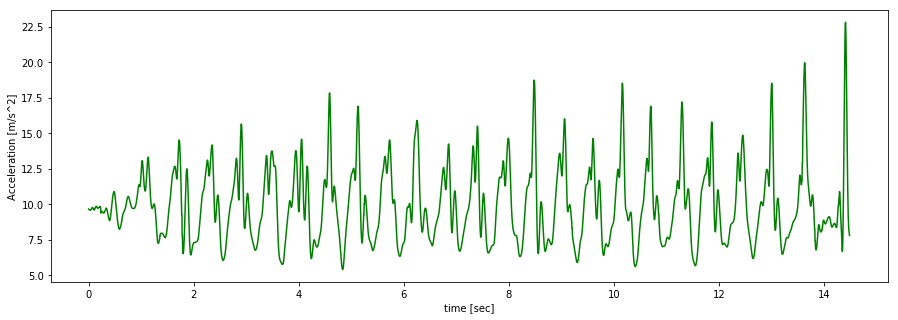

In [9]:
# plot acceleration
fig = plt.figure(figsize=(15,5))
plt.plot(acc_1['time'],acc_1['acceleration'], '-g')
plt.xlabel('time [sec]')
plt.ylabel('Acceleration [m/s^2]')
plt.show()

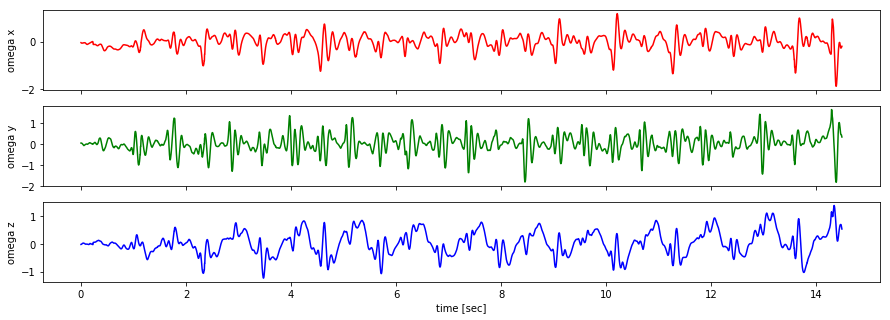

In [10]:
# plot gyroscope data in each axes
fig, axs = plt.subplots(nrows=3, ncols=1,sharex=True, figsize=(15,5))

axs[0].plot(gyro_1['time'],gyro_1['x'], '-r')
axs[0].set_ylabel('omega x')

axs[1].plot(gyro_1['time'],gyro_1['y'], '-g')
axs[1].set_ylabel('omega y')

axs[2].plot(gyro_1['time'],gyro_1['z'], '-b')
axs[2].set_ylabel('omega z')

axs[2].set_xlabel('time [sec]')


plt.show()

In [11]:
def vector2anti_Sim(v):
    return np.array([[0,-v[2],v[1]],[v[2],0,-v[0]],[-v[1],v[0],0]])

In [12]:
# Initial parameters
Re = 6378137
e = 0.0818191908
omega_ie = (2*np.pi)/(24*60*60) # Earth turn rate

# Calc' initial angles (10 sec' in stationary conditions
# fx = acc_1['x'].mean()
# fy = acc_1['y'].mean()
# fz = acc_1['z'].mean()

fx = acc_1.loc[5,'x']
fy = acc_1.loc[5,'y']
fz = acc_1.loc[5,'z']

roll_0 = np.arctan2(-fy, -fz)
pitch_0 = np.arctan2(-fx, np.sqrt(fz**2 + fy**2))
# from compass
yaw_0 = np.deg2rad(230)

# from google map
lat_0 = np.deg2rad(32.780724)
lon_0 = np.deg2rad(35.020606)
h_0 = 183

v_0 = np.array([[0,0,0]]).T
# r_0 = np.array([[lat_0, lon_0, h_0]]).T
r_0 = np.array([[0, 0, 0]]).T

Rm = Re * (1 - e ** 2) / (1 - e ** 2 * sin(lat_0) * 2) ** (3 / 2)
Rn = Re / (1 - e ** 2 * sin(lat_0) * 2) ** (1 / 2)
g = 9.7803 + 0.051799*sin(lat_0) - h_0*0.94114/1000000
gn = np.array([[0,0,g]]).T

In [13]:
# Rotation matrix
T_roll = np.array([[cos(roll_0),0,-sin(roll_0)],[0,1,0],[sin(roll_0),0,cos(roll_0)]])
T_pitch = np.array([[1,0,0],[0,cos(pitch_0),sin(pitch_0)],[0,-sin(pitch_0),cos(pitch_0)]])
T_yaw = np.array([[cos(yaw_0),sin(yaw_0),0],[-sin(yaw_0),cos(yaw_0),0],[0,0,1]])

tb_n_0 = T_roll.dot(T_pitch.dot(T_yaw))

In [14]:
# find the time interval between every sample
n = acc_1.shape[0]
samples = acc_1.to_numpy()
dt = samples[1:n, 0] - samples[0:(n - 1), 0]
# dt = np.average(dt)

In [15]:
# init the lists of the navigation solution
Pose = [r_0]
Velocity = [v_0]
Attitude = [tb_n_0]

In [16]:
for i in range(n-1):

    # calculate next Tb_n
    sigma_x = dt[i] * vector2anti_Sim(gyro_1.iloc[i,1:4])
    sigma = np.sqrt(sigma_x[0,1]**2 + sigma_x[0,2]**2 + sigma_x[1,2]**2)
    tb_n = tb_n_0.dot(np.identity(3) + (sin(sigma)/sigma)*sigma_x + ((1-cos(sigma))/sigma**2)*np.dot(sigma_x, sigma_x))

    Attitude.append(tb_n)

    # calculate next V dot

    # phi = r_0[0,0]
    # h = r_0[2,0]
    phi = lat_0
    h = h_0
    # full calculation
    # omega_ie_n =  vector2anti_Sim(np.array([omega_ie*cos(phi),0,-omega_ie*sin(phi)]))
    # omega_en = vector2anti_Sim(np.array([-v_0[1,0]/(Rn+h),-v_0[0,0]/(Rm+h),-v_0[1,0]*np.tan(phi)/(Rn+h)]))
    # f_b =g*row[1:4][:, np.newaxis]
    # v_dot = np.dot(tb_n, f_b) + gn - np.dot(omega_en+2*omega_ie_n, v_0)

    f_b = acc_1.iloc[i,1:4][:, np.newaxis]
    # simplify
    v_dot = np.dot(tb_n, f_b) + gn

    # calculate next V
    v = v_0 + dt[i]*v_dot
    Velocity.append(v)

    # calculate next position
    # D = np.dot(np.identity(3),np.array([1/(Rm+h),1/(cos(phi)*(Rn+h)),-1]))
    # D = np.diag(np.array([1/(Rm+h),1/(cos(phi)*(Rn+h)),-1]))
    # r_dot = np.dot(D, v)

    # simplify
    r_dot = v

    # calculate next R
    r = r_0 + dt[i]*r_dot
    Pose.append(r)

    tb_n_0 = tb_n
    v_0 = v
    r_0 = r

In [17]:
Velocity = np.reshape(np.array(Velocity),(len(Velocity),3))
Pose = np.reshape(np.array(Pose),(len(Pose),3))
Attitude = np.array(Attitude)

In [18]:
# transform R from rad to degrees (lat,lon,h)
# Pose[:,0:2] = np.rad2deg(Pose[:,0:2])

V_norm = np.sqrt(Velocity[:, 0]**2 + Velocity[:,1]**2 + Velocity[:,2]**2)

print('start point [lat,lon,h]:',Pose[0])
print('end point [lat,lon,h]:', Pose[-1])
# deg_to_meter = 108000
deltaX = np.sqrt((Pose[-1, 0]-Pose[0, 0])**2 + (Pose[-1, 1]-Pose[0, 1])**2) # * deg_to_meter
deltaH = Pose[-1,2] - Pose[0,2]
print('total dist [m]:', deltaX)
print('altitude change [m]:', deltaH)
print('average speed [m/sec]:', np.average(V_norm))

start point [lat,lon,h]: [0. 0. 0.]
end point [lat,lon,h]: [ 5299395.11363192 18140173.98597272 37854361.40567548]
total dist [m]: 18898399.42460068
altitude change [m]: 37854361.40567548
average speed [m/sec]: 15002.418845466264


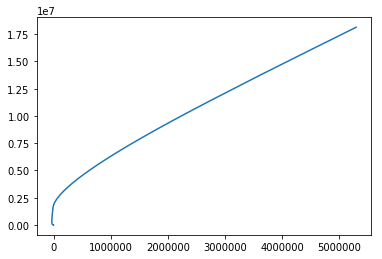

In [19]:
plt.figure()
plt.plot(Pose[:,0],Pose[:,1])